In [1]:
import requests
import os
import json
import time

In [2]:
nyt_api_key = os.getenv('NYT_ACCESS_KEY')
articlesearch_url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json'
print('Value of the environment variable for api-key: ', nyt_api_key)

Value of the environment variable for api-key:  d49f3c0b89e942cb9f94f89a30e69e7f


In [3]:
# Request Map for Accidents
reqparams = {'api-key':nyt_api_key, 'q':'road accident','begin_date':'20120101', 'end_date':'20161231', 'page':3}

r = requests.get(articlesearch_url, params = reqparams)
if r.status_code == 200:
    jsonObj = json.loads(r.text)
    # get total hits to prepare for dynamically getting remaining docs
    hits = jsonObj['response']['meta']['hits']
    print('Hits count:', hits)
    remaining_pages = int(hits / 10)
    if hits % 10 == 0:
        remaining_pages = remaining_pages - 1
print('Remaining pages:', remaining_pages)
print(jsonObj['response']['docs'][4])

counter = 0
for doc in jsonObj['response']['docs']:
    print('Page:', 0, 'Doc:', counter)
    for kw in doc['keywords']:
        if kw.get('name') == 'glocations':
            print(kw['name'],kw['value'])
    counter = counter + 1

Hits count: 2579
Remaining pages: 257
{'slideshow_credits': None, 'section_name': 'World', 'web_url': 'http://www.nytimes.com/reuters/2014/09/09/world/americas/09reuters-haiti-accident.html', 'byline': {'organization': 'REUTERS', 'original': 'By REUTERS', 'person': []}, 'type_of_material': 'News', 'blog': [], 'pub_date': '2014-09-09T21:09:17Z', 'news_desk': None, 'subsection_name': 'Americas', 'multimedia': [], 'lead_paragraph': 'A truck accident killed 24 people and injured 37 on Tuesday on a highway in southern Haiti near the city of Petit-Go&#226;ve, officials said.', 'headline': {'print_headline': 'Road Accident in Southern Haiti Kills 24, Injures 37', 'main': 'Road Accident in Southern Haiti Kills 24, Injures 37'}, 'print_page': None, 'keywords': [], 'document_type': 'article', 'word_count': '137', '_id': '540fa58638f0d87641c68011', 'snippet': 'A truck accident killed 24 people and injured 37 on Tuesday on a highway in southern Haiti near the city of Petit-Go&#226;ve, officials sa

In [4]:
for page_number in range(1, remaining_pages + 1):
        if page_number % 5:
            # API restriction: sleep 1 sec after every 5 request 
            time.sleep(1)
        reqparams['page'] = page_number
        print('Requesting info for page:', page_number)
        r = requests.get(articlesearch_url, params = reqparams)
        if r.status_code == 200:
            jsonObj = json.loads(r.text)
            print('Got results for page:',jsonObj['response']['meta']['offset'] / 10)
            counter = 0
            for doc in jsonObj['response']['docs']:
                print('Page:', page_number, 'Doc:', counter)
                for kw in doc['keywords']:
                    if kw.get('name') == 'glocations':
                        print(kw['name'],kw['value'])
                counter = counter + 1
        else:
            print('Failed to get docs for page:', page_number)
            print(r.text)

Requesting info for page: 1
Got results for page: 1.0
Page: 1 Doc: 0
glocations Cameroon
Page: 1 Doc: 1
glocations Georgia
Page: 1 Doc: 2
glocations Bronx River Parkway (NY)
Page: 1 Doc: 3
glocations Woodside (Queens, NY)
Page: 1 Doc: 4
Page: 1 Doc: 5
Page: 1 Doc: 6
Page: 1 Doc: 7
Page: 1 Doc: 8
Page: 1 Doc: 9
Requesting info for page: 2
Got results for page: 2.0
Page: 2 Doc: 0
glocations Ghana
glocations Kintampo (Ghana)
Page: 2 Doc: 1
glocations London (England)
glocations Great Britain
glocations London (England)
Page: 2 Doc: 2
glocations Poland
glocations Russia
Page: 2 Doc: 3
Page: 2 Doc: 4
Page: 2 Doc: 5
Page: 2 Doc: 6
Page: 2 Doc: 7
Page: 2 Doc: 8
Page: 2 Doc: 9
Requesting info for page: 3
Got results for page: 3.0
Page: 3 Doc: 0
Page: 3 Doc: 1
glocations Poland
glocations Russia
Page: 3 Doc: 2
Page: 3 Doc: 3
Page: 3 Doc: 4
Page: 3 Doc: 5
Page: 3 Doc: 6
Page: 3 Doc: 7
Page: 3 Doc: 8
Page: 3 Doc: 9
Requesting info for page: 4
Got results for page: 4.0
Page: 4 Doc: 0
Page: 4 Doc: 

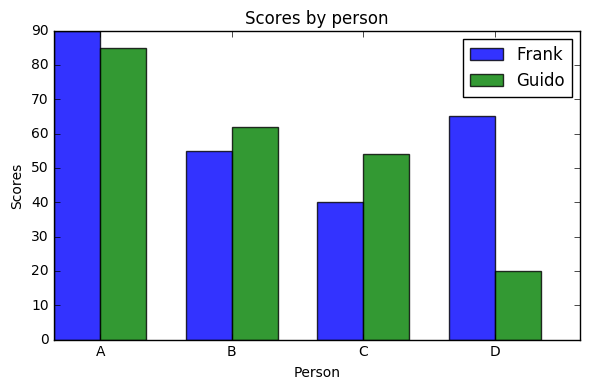

In [6]:
import numpy as np
import matplotlib.pyplot as plt
 
# data to plot
n_groups = 4
means_frank = (90, 55, 40, 65)
means_guido = (85, 62, 54, 20)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, means_frank, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Frank')
 
rects2 = plt.bar(index + bar_width, means_guido, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Guido')
 
plt.xlabel('Person')
plt.ylabel('Scores')
plt.title('Scores by person')
plt.xticks(index + bar_width, ('A', 'B', 'C', 'D'))
plt.legend()
 
plt.tight_layout()
plt.show()